<a href="https://colab.research.google.com/github/clashleyuncc/Intro-To-ML/blob/main/Final-Project/MLProjectFCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cuda

Energy Consumption by Day of the Week:
  Day_of_week  Usage_kWh
4    Thursday  175279.52
5     Tuesday  171862.65
1      Monday  168636.34
0      Friday  165709.51
6   Wednesday  161013.14
2    Saturday   79467.75
3      Sunday   37667.80
Target classes: ['Light_Load' 'Maximum_Load' 'Medium_Load']
Esimated run time for 1000 Epoch: 0.039 minutes
0.0024480819702148438 Seconds, Epoch 1, Training Loss 1.0649125576019287, Validation Loss 1.0641709566116333
0.9665358066558838 Seconds, Epoch 500, Training Loss 1.0428211688995361, Validation Loss 1.0411778688430786
1.8420367240905762 Seconds, Epoch 1000, Training Loss 1.029321312904358, Validation Loss 1.0270096063613892


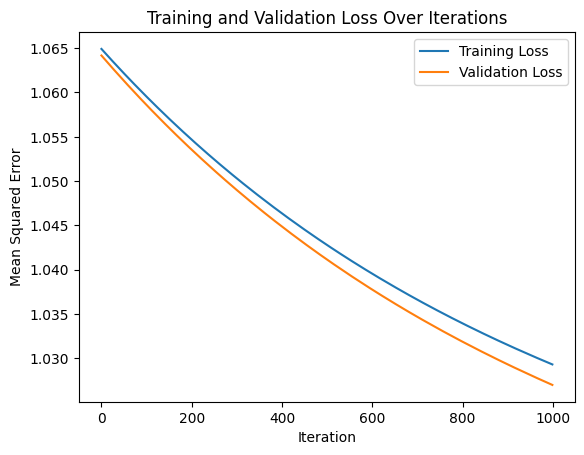

In [9]:

# Use of Logistic Regression to classify UC Irvine's
# "Steel Industry Energy Consumption" dataset into Light, Medium,
# and Maximum load

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from collections import OrderedDict
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val,
                  t_c_train, t_c_val):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train)
        loss_train = loss_fn(t_p_train, t_c_train)

        t_p_val = model(t_u_val)
        loss_val = loss_fn(t_p_val, t_c_val)

        t_u_train_device = t_u_train.to(device)
        t_c_train_device = t_c_train.to(device)

        t_p_train = model(t_u_train_device)
        loss_train = loss_fn(t_p_train, t_c_train_device)

        t_u_val_device = t_u_val.to(device)
        t_c_val_device = t_c_val.to(device)

        t_p_val = model(t_u_val_device)
        loss_val = loss_fn(t_p_val, t_c_val_device)

        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        train_losses.append(loss_train)
        val_losses.append(loss_val)

        if epoch == 1:
          print('Esimated run time for {} Epoch: {} minutes'.format(
                n_epochs, round((time.time()-start_time)*n_epochs/60,3)))
        if epoch == 1 or epoch % 500 == 0:
          print('{} Seconds, Epoch {}, Training Loss {}, Validation Loss {}'.format(
              time.time()-start_time, epoch, loss_train.item(), loss_val.item()))

!pip3 install -U ucimlrepo
from ucimlrepo import fetch_ucirepo

# fetch dataset
steel_industry_energy_consumption = fetch_ucirepo(id=851)

y = steel_industry_energy_consumption.data.targets
X = steel_industry_energy_consumption.data.features

# Check for missing values and handle them
if X.isnull().sum().any():
    X = X.fillna(X.median())  # Replace missing values with median

# Analyze energy consumption by day of the week
if 'Day_of_week' in X.columns:
    energy_by_day = X.groupby('Day_of_week')['Usage_kWh'].sum().reset_index()
    energy_by_day = energy_by_day.sort_values(by='Usage_kWh', ascending=False)
    print("\nEnergy Consumption by Day of the Week:")
    print(energy_by_day)

# Encode categorical features if they exist
categorical_columns = ['WeekStatus', 'Day_of_week']
for col in categorical_columns:
    if col in X.columns:
        X = pd.get_dummies(X, columns=[col], drop_first=True, dtype='float')
# Identify and scale continuous features if they exist
continuous_columns = [
    'Usage_kWh', 'Lagging_Current_Reactive.Power_kVarh',
    'Leading_Current_Reactive_Power_kVarh', 'CO2(tCO2)',
    'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM'
]
existing_continuous_columns = [col for col in continuous_columns if col in X.columns]
scaler = StandardScaler()
X[existing_continuous_columns] = scaler.fit_transform(X[existing_continuous_columns])

# Ensure y is a Series if it's a single-column DataFrame
if isinstance(y, pd.DataFrame):
    y = y.iloc[:, 0]  # Extract the first column as a Series

# Encode target variable if categorical
if y.dtype == 'object' or isinstance(y.iloc[0], str):
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)
    print("Target classes:", label_encoder.classes_)

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

t_c = y
#t_u = X
t_c = torch.tensor(t_c)
t_u = torch.tensor(X.to_numpy())

t_u = t_u.to(torch.float32).to(device)
#t_c = t_c.to(torch.float32).to(device)
t_c = t_c.to(torch.long).to(device)

n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)
shuffled_indices = torch.randperm(n_samples)
train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]
t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]
t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]
t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val

train_losses = []
val_losses = []

seq_model = nn.Sequential(OrderedDict([
            ('hidden_linear1', nn.Linear(14, 16)),
            ('hidden_activation1', nn.Tanh()),
            ('output_linear', nn.Linear(16,3))
]))

seq_model.to(device)
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3)
start_time = time.time()

training_loop(
    n_epochs = 1000,
    optimizer = optimizer,
    model = seq_model,
    #loss_fn = nn.MSELoss(),
    loss_fn = nn.CrossEntropyLoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val,
    t_c_train = t_c_train,
    t_c_val = t_c_val)

train_losses_cpu = torch.tensor(train_losses).cpu().numpy()
val_losses_cpu = torch.tensor(val_losses).cpu().numpy()

with torch.no_grad():
  plt.plot(train_losses_cpu, label="Training Loss")
  plt.plot(val_losses_cpu, label="Validation Loss")
  plt.xlabel("Iteration")
  plt.ylabel("Mean Squared Error")
  plt.legend()
  plt.title("Training and Validation Loss Over Iterations")
  plt.show()



In [ ]:
##

model = LogisticRegression(penalty='l1', C=0.001, solver='liblinear')
model.fit(X_train, Y_train)
predicted = model.predict(X_test)

##

matrix = confusion_matrix(Y_test, predicted)

cnf_matrix = confusion_matrix(Y_test, predicted)

report = classification_report(Y_test, predicted)
print(report)

##

class_names=['Light','Medium','Maximum'] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(matrix), annot=True, cmap="YlGnBu" ,fmt='g',
            xticklabels=class_names, yticklabels=class_names)
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion Matrix', y=1.1)
plt.ylabel('Actual Load Type')
plt.xlabel('Predicted Load Type')
plt.show()